In [73]:
!pip install --user --trusted-host pypi-service.pypi --index-url http://pypi-service.pypi:8080/ sklearn

Looking in indexes: http://pypi-service.pypi:8080/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=0032c65054c4e01ada60f1421a435db9510828b5c93c3b409c786f67b92f9d60
  Stored in directory: /home/jovyan/.cache/pip/wheels/5a/66/e7/f2bbd87b7ae75f6159d4fd57ec3cc1c530c1b19b304a1716f6
Successfully built sklearn


In [240]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import pandas_udf, udf, size, length, when, col, array_contains, row_number, lit
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, IntegerType, ArrayType, StringType, StructType, StructField, DateType
from pyspark.sql.window import Window
from pyspark.sql.functions import pandas_udf
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from statistics import mean, stdev

import matplotlib.pyplot as plt
import datetime, time 
import emoji
import re
import socket
import pandas as pd
import numpy as np

In [2]:
LOCAL_IP = socket.gethostbyname(socket.gethostname())
spark = (
    SparkSession
    .builder
    .master('k8s://https://10.32.7.103:6443')
    .config("spark.driver.host", LOCAL_IP)
    .config("spark.driver.bindAddress", "0.0.0.0")
    .config('spark.executor.instences', '2')
    .config('spark.executor.cores', '2')
    .config('spark.cores.max', '4')
    .config('spark.executor.memory', '4g')
    .config('spark.sql.execution.arrow.enabled', 'true')
    .config('spark.kubernetes.namespace', 'zpinaev-244202')
    .config('spark.kubernetes.container.image', 'node03.st:5000/spark-executor:zpinaev-244202')
    .config("spark.kubernetes.container.image.pullPolicy", "Always")
    .config('spark.kubernetes.executor.deleteOnTermination', 'false')
    .getOrCreate()
)

In [32]:
preds_df = spark.read\
                .parquet("hdfs:///tmp/vshishkov-243998/project_data/preds/LinearRegression_aave-usd.parquet")
                
preds_df.show(10)

+-------------------+--------------------+
|             target|          prediction|
+-------------------+--------------------+
| 1.5434267216982664|  2.0427243539198217|
| 0.4209528633973711|  0.4725503325269045|
|0.48446295930137595|-0.20330700243302816|
|0.33664444540659016|  0.9999394547350783|
|0.12772982981743183|  0.3417761784670134|
|-0.6164723371777932| -0.6536933077937467|
|-1.2582528850942512|  -1.266468295761551|
| 0.6766494524474193|  0.6827303031464702|
| 1.1071552154750104|  1.2259051877517029|
|  0.996971267045149|  2.0472631660977854|
+-------------------+--------------------+
only showing top 10 rows



In [14]:
coins_list = ['lrc-usd', 'axs-usd', 'xrp-usd', 'uni1-usd', 'ada-usd', 'fil-usd', 'dot-usd', 'rep-usd', 'icp-usd', 'bnb-usd', 'xmr-usd', 'doge-usd', 'aave-usd', 'ltc-usd', 'zil-usd', 'link-usd', 'vet-usd']
models_list = ['LinearRegression', 'RandomForestRegressor']

coins_list_Bcs = spark.sparkContext.broadcast(coins_list)
models_list_Bcs = spark.sparkContext.broadcast(models_list)

In [94]:
def std_cor(data):
    data_mean = mean(data)
    res = 0
    for x in data:
        res += pow((x - data_mean),2)
    res = pow((res / len(data)),(1/2))
    return res

In [225]:
def get_pred(coin_name, model_type, date):
    
    models_list = models_list_Bcs.value
    coins_list = coins_list_Bcs.value
    
    if not model_type in models_list:
        print("Error: wrong model type")
        return
    if not coin_name in coins_list:
        print("Error: wrong coin name")
        return
    
    coin_data = spark.read\
                   .csv(f"hdfs:///tmp/vshishkov-243998/project_data/currencies/{coin_name.upper()}.csv", header=True)\
                   .withColumn("id_n", F.monotonically_increasing_id())
    
    windowSpec = Window.orderBy(col("id_n"))
    coin_data = coin_data.withColumn("id",row_number().over(windowSpec)-1).drop("id_n")
    
    
    if coin_data.where(col("Date") == date).count() == 0:
        print("Error: wrong date or no pred for passed date")
        return
    
    pred_df = spark.read\
                   .parquet(f"hdfs:///tmp/vshishkov-243998/project_data/preds/{model_type}_{coin_name}.parquet") \
                   .withColumn("id_n", F.monotonically_increasing_id())
    
    pred_df = pred_df.withColumn("id",row_number().over(windowSpec)-1).drop("id_n")
    
    id_1 = coin_data.where(col("Date") == date).select("id").head()[0]
    
    id_2 = pred_df.count() - ( coin_data.count() - id_1 )
    
    target_sc = pred_df.where(col("id") == id_2).select("target").head()[0]
    pred_sc = pred_df.where(col("id") == id_2).select("prediction").head()[0]
    
    coin_close_data = [float(row["Close"]) for row in coin_data.select("Close").collect()]
    N_elem = coin_data.count() - pred_df.count() - 1
    coin_close_data = coin_close_data[:N_elem]
    
    data_mean = mean(coin_close_data)
    data_std = std_cor(coin_close_data)
    

    target = target_sc * data_std + data_mean
    pred = pred_sc * data_std + data_mean
    
    return target, pred
    

In [228]:
model_type = "LinearRegression"
coin = "aave-usd"
date = "2022-06-06"

target, pred = get_pred(coin, model_type, date)
print("Target: ", target)
print("Prediction: ", pred)

Target:  108.20206448522916
Prediction:  108.98950356890762


In [237]:
def get_pred_period(dates, coin_name, model_type):
    
    targets = []
    predicts = []
    
    for date in dates:
        target, pred = get_pred(coin_name, model_type, date)
        targets.append(target)
        predicts.append(pred)
    
    return targets, predicts

In [258]:
def get_pred_period_2_models(dates, coin_name):
    
    model_type_1 = "LinearRegression"
    model_type_2 = "RandomForestRegressor"
    
    targets = []
    predicts1 = []
    predicts2 = []
    
    for date in dates:
        target, pred = get_pred(coin_name, model_type_1, date)
        target2, pred2 = get_pred(coin_name, model_type_2, date)
        targets.append(target)
        predicts1.append(pred)
        predicts2.append(pred2)
    
    return targets, predicts1, predicts2

In [238]:
model_type = "LinearRegression"
coin_name = "aave-usd"

coin_data = spark.read\
                   .csv(f"hdfs:///tmp/vshishkov-243998/project_data/currencies/{coin_name.upper()}.csv", header=True)

dates = [row["Date"] for row in coin_data.select("Date").collect()]
N_el = round(coin_data.count() * 0.19)
dates = dates[-N_el:]


targets, predicts = get_pred_period(dates, coin_name, model_type)


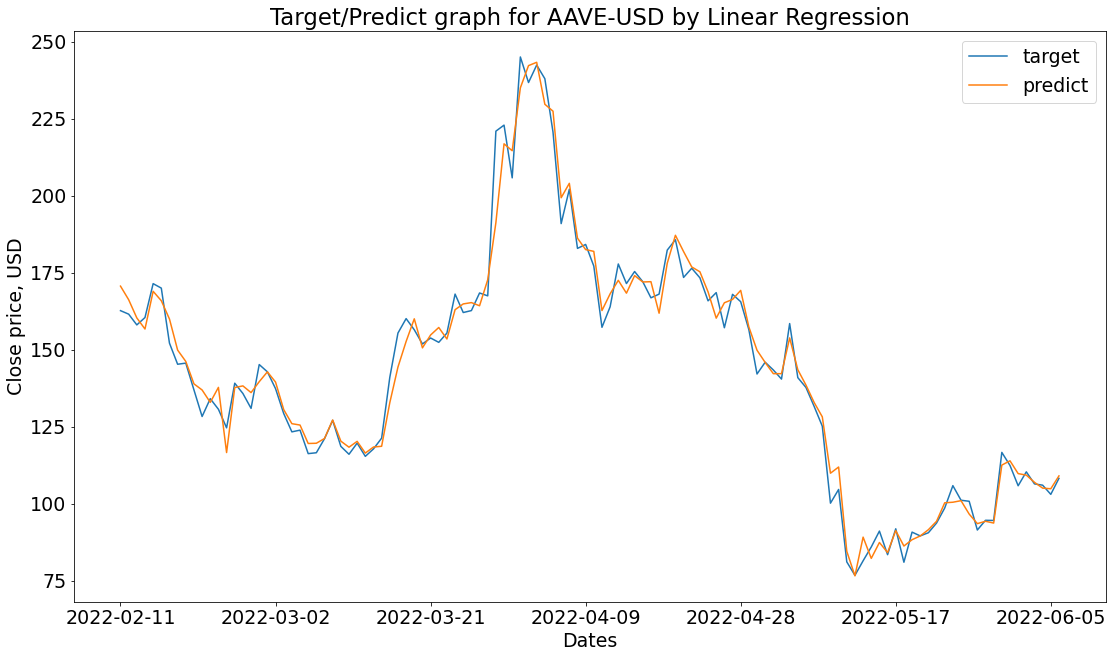

In [257]:
plt.plot(dates, targets, label = "target")

plt.plot(dates, predicts, label = "predict")
plt.xlabel('Dates')

plt.ylabel('Close price, USD')

plt.title('Target/Predict graph for AAVE-USD by Linear Regression')

plt.legend()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.xticks(np.arange(0, len(dates)+1, 19))

plt.rcParams.update({'font.size': 19})

plt.show()

In [268]:
coin_name = "zil-usd"

coin_data = spark.read\
                   .csv(f"hdfs:///tmp/vshishkov-243998/project_data/currencies/{coin_name.upper()}.csv", header=True)

dates = [row["Date"] for row in coin_data.select("Date").collect()]
N_el = round(coin_data.count() * 0.19)
dates = dates[-N_el:]


targets, predicts1, predicts2 = get_pred_period_2_models(dates, coin_name)

In [ ]:
plt.plot(dates, targets, label = "target")

plt.plot(dates, predicts1, label = "linear regression")

plt.plot(dates, predicts2, label = "random forest regressor")

plt.xlabel('Dates')

plt.ylabel('Close price, USD')

plt.title('Target/Predict graph for ZIL-USD')

plt.legend()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.xticks(np.arange(0, len(dates)+1, 19))

plt.rcParams.update({'font.size': 19})

plt.show()